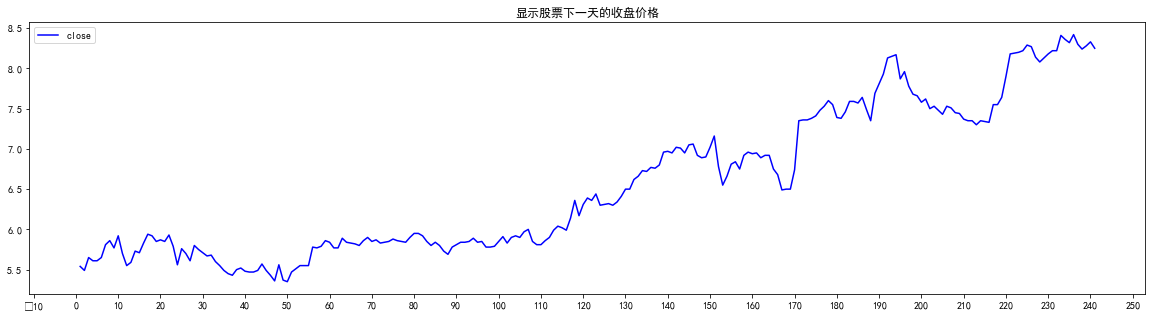

In [8]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 生成标签值：下一天收盘价（涉及删除最后一条数据，不要重复执行该函数）
def generate_label(data_path):
   df = pd.read_csv(data_path,encoding="unicode_escape")
   next_close = list()
   for i in range(len(df['close']) - 1):     
       next_close.append(df['close'][i + 1])
   next_close.append(0)
   df['next_close'] = next_close
   df.drop(df.index[-1], inplace=True)
   df.to_csv('data1.csv', index=None)
df = pd.read_csv('data1.csv',encoding="unicode_escape")
datas =df['next_close'][1:]
plt.figure(facecolor='white',figsize=(20,5))
datas.plot(color='blue', label='close')
plt.legend(loc='best')
plt.title(U"显示股票下一天的收盘价格")
ax = plt.gca()
ax.locator_params('x',nbins=50) #调整x轴
ax.locator_params('y',nbins=10) #调整y轴
plt.show()

In [2]:


# 分割数据集生成训练和测试数据
def generate_model_data(data_path,alpha,days):
    df = pd.read_csv(data_path,encoding="unicode_escape")
    train_day = int((len(df['close']) - days + 1))
    for property in ['open', 'close', 'high', 'low', 'volume','next_close']:
        df[property] = scaler.fit_transform(np.reshape(np.array(df[property]), (-1, 1)))
    X_data, Y_data = list(), list()
    # 生成时序数据
    for i in range(train_day):
        Y_data.append(df['next_close'][i+days-1])
        for j in range(days):
            for m in ['open', 'close', 'high', 'low', 'volume']:
                X_data.append(df[m][i + j])
    X_data = np.reshape(np.array(X_data),(-1,5*15))# 5表示特征数量*天数
    #训练长度为时间*权重alpha
    train_length = int(len(Y_data)* alpha)
    X_train = np.reshape(np.array(X_data[:train_length]),(len(X_data[:train_length]),days,5))
    X_test = np.reshape(np.array(X_data[train_length:]),(len(X_data[train_length:]),days,5))
    Y_train,Y_test = np.array(Y_data[:train_length]),np.array(Y_data[train_length:])
    return X_train,Y_train,X_test,Y_test
#计算平均绝对百分比误差
def calc_MAPE(real,predict):
    Score_MAPE = 0
    #预测值- 真实值/真实值累加（即为MAE）
    for i in range(len(predict[:, 0])):
        Score_MAPE += abs((predict[:, 0][i] - real[:, 0][i]) / real[:, 0][i])
    #MAPE=MAE/n*100%
    Score_MAPE = Score_MAPE * 100 / len(predict[:, 0])
    return Score_MAPE
#计算改进后的平均绝对百分比误差
def calc_AMAPE(real,predict):
    Score_AMAPE = 0
    Score_MAPE_DIV = sum(real[:, 0]) / len(real[:, 0])
    for i in range(len(predict[:, 0])):
        Score_AMAPE += abs((predict[:, 0][i] - real[:, 0][i]) / Score_MAPE_DIV)
    Score_AMAPE = Score_AMAPE * 100 / len(predict[:, 0])
    return Score_AMAPE
#结果评估
def evaluate(real,predict):
    #计算均方根误差
    RMSE = math.sqrt(mean_squared_error(real[:, 0], predict[:, 0]))
    #计算平均绝对误差
    MAE = mean_absolute_error(real[:, 0], predict[:, 0])
    #平均绝对百分比误差
    MAPE = calc_MAPE(real, predict)
    #改进的平均绝对百分比误差
    AMAPE = calc_AMAPE(real, predict)
    return RMSE,MAE,MAPE,AMAPE
#LSTM预测模型
def lstm_model(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    
    model.add(LSTM(units=20, input_shape=(X_train.shape[1], X_train.shape[2])))
    # 定义了一个有1个神经元，使用hard_sigmoid激活函数的神经层
    model.add(Dense(1, activation='hard_sigmoid'))
    # 编译模型，损失函数设为均方误差，优化器为adam
    model.compile(loss='mean_squared_error', optimizer='adam')
    
# 拟合/训练模型，batch_size，进行梯度下降时每个batch包含的样本数为20，epochs: 训练时全部样本的迭代次数为200，verbose = 1 为输出进度条记录
    model.fit(X_train, Y_train, epochs=200, batch_size=20, verbose=1)
    #使用predict()方法进行预测
    trainPredict = model.predict(X_train)
    #将标准化后的数据转换为原始数据
    trainPredict = scaler.inverse_transform(trainPredict)
    Y_train = scaler.inverse_transform(np.reshape(Y_train, (-1, 1)))

    testPredict = model.predict(X_test)
    testPredict = scaler.inverse_transform(testPredict)
    Y_test = scaler.inverse_transform(np.reshape(Y_test, (-1, 1)))

    return Y_train, trainPredict, Y_test, testPredict

In [3]:
#data_path = 'hs300.csv'
data_path = 'data.csv'
#days为输入层向量的维度
days = 15
#alpha是学习速度
alpha = 0.8
generate_label(data_path)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train, Y_train, X_test, Y_test = generate_model_data('data1.csv',alpha,days)
train_Y, trainPredict, test_Y, testPredict  = lstm_model(X_train, Y_train, X_test, Y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
182/182 [==============================] - 1s 4ms/step - loss: 0.0851
Epoch 2/200
182/182 [==============================] - 0s 286us/step - loss: 0.0770
Epoch 3/200
182/182 [==============================] - 0s 303us/step - loss: 0.0676
Epoch 4/200
182/182 [==============================] - 0s 297us/step - loss: 0.0547
Epoch 5/200
182/182 [==============================] - 0s 286us/step - loss: 0.0358
Epoch 6/200
182/182 [==============================] - 0s 297us/step - loss: 0.0143
Epoch 7/200
182/182 [==============================] - 0s 275us/step - loss: 0.0059
Epoch 8/200
182/182 [==============================] - 0s 369us/step - loss: 0.0068
Epoch 9/200
182/182 [==============================] - 0s 364us/step - loss: 0.0058
Epoch 10/200
182/182 [==============================] - 0s 358us/step - loss: 0.0055
Epoch 11/200
182/182 [===================

Epoch 185/200
182/182 [==============================] - 0s 275us/step - loss: 8.8168e-04
Epoch 186/200
182/182 [==============================] - 0s 275us/step - loss: 8.7888e-04
Epoch 187/200
182/182 [==============================] - 0s 270us/step - loss: 9.0786e-04
Epoch 188/200
182/182 [==============================] - 0s 281us/step - loss: 8.5172e-04
Epoch 189/200
182/182 [==============================] - 0s 275us/step - loss: 8.8289e-04
Epoch 190/200
182/182 [==============================] - 0s 275us/step - loss: 8.9411e-04
Epoch 191/200
182/182 [==============================] - 0s 292us/step - loss: 9.1385e-04
Epoch 192/200
182/182 [==============================] - 0s 281us/step - loss: 9.6734e-04
Epoch 193/200
182/182 [==============================] - 0s 275us/step - loss: 9.5119e-04
Epoch 194/200
182/182 [==============================] - 0s 275us/step - loss: 8.4103e-04
Epoch 195/200
182/182 [==============================] - 0s 281us/step - loss: 8.5217e-04
Epoch 196/

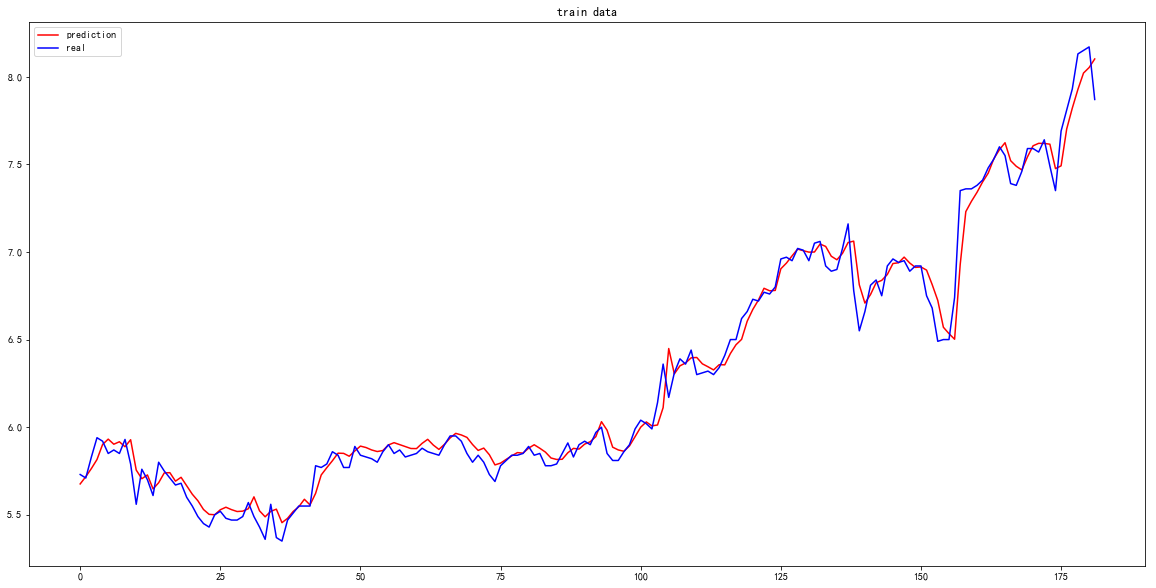

In [4]:
plt.figure(facecolor='white',figsize=(20,10))
plt.plot(list(trainPredict), color='red', label='prediction')
plt.plot(list(train_Y), color='blue', label='real')
plt.legend(loc='upper left')
plt.title('train data')
plt.show()

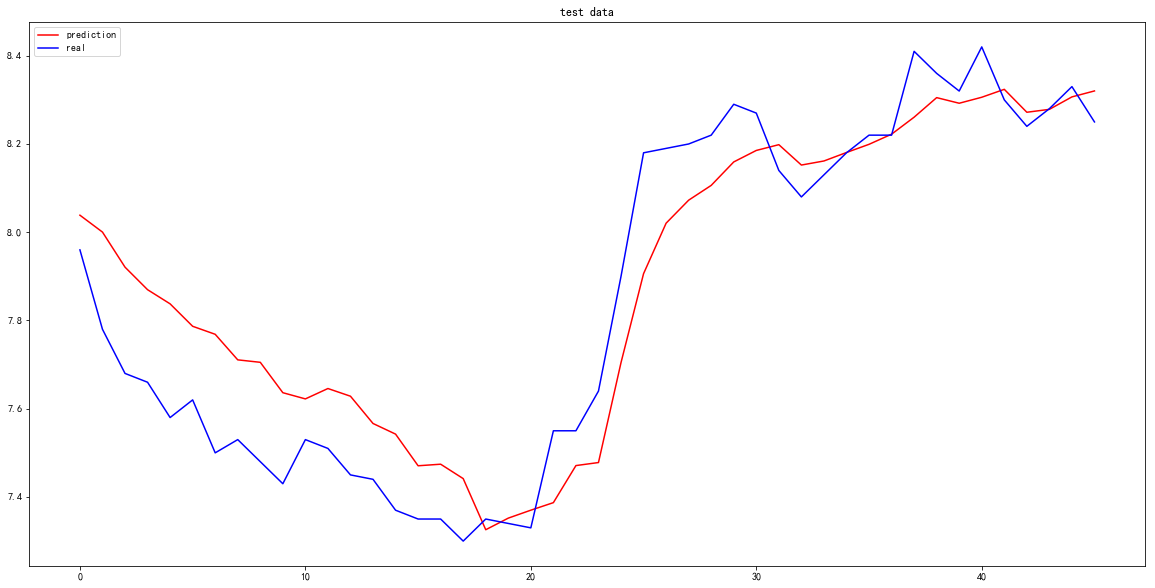

In [5]:
plt.figure(facecolor='white',figsize=(20,10))
plt.plot(list(testPredict), color='red', label='prediction')
plt.plot(list(test_Y), color='blue', label='real')
plt.legend(loc='upper left')
plt.title('test data')
plt.show()

In [6]:

RMSE,MAE,MAPE,AMAPE = evaluate(test_Y,testPredict)
print(RMSE,MAE,MAPE,AMAPE)

0.14115744240136785 0.11749827758125629 1.517734143757162 1.4955094681214656
